In [1]:
import pandas as pd
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")

torch.__version__

'2.0.1+cu117'

Data link : https://www.kaggle.com/datasets/jangedoo/utkface-new


### Preprocessing Our Raw Data
1. Creating dataframe for our features

In [2]:
import os

dir = 'UTKFace'
files = [filename for filename in os.listdir(dir)]

data = {'path' : files}

df = pd.DataFrame(data)

df

path
0      50_0_0_20170117135034485.jpg.chip.jpg
1      55_0_3_20170119171117830.jpg.chip.jpg
2      12_0_4_20170103201607807.jpg.chip.jpg
3      40_0_0_20170117172519480.jpg.chip.jpg
4      39_1_3_20170104233629347.jpg.chip.jpg
...                                      ...
23703  65_0_0_20170111200641250.jpg.chip.jpg
23704  26_1_0_20170116234741431.jpg.chip.jpg
23705  55_0_0_20170120140655585.jpg.chip.jpg
23706  60_1_0_20170110122614299.jpg.chip.jpg
23707  38_0_1_20170116200942002.jpg.chip.jpg

[23708 rows x 1 columns]

The features for this dataset is provided in the filename itself `[age]_[gender]_[race]_[date&time].jpg`

In [8]:
## adding extra features to our dataframe

temp = []
for x in df['path']:
    temp.append(x.split('_'))


temp = pd.DataFrame(temp)

columns = ['age','gender','race','date']

temp.columns = columns

temp



age gender race                            date
0      50      0    0  20170117135034485.jpg.chip.jpg
1      55      0    3  20170119171117830.jpg.chip.jpg
2      12      0    4  20170103201607807.jpg.chip.jpg
3      40      0    0  20170117172519480.jpg.chip.jpg
4      39      1    3  20170104233629347.jpg.chip.jpg
...    ..    ...  ...                             ...
23703  65      0    0  20170111200641250.jpg.chip.jpg
23704  26      1    0  20170116234741431.jpg.chip.jpg
23705  55      0    0  20170120140655585.jpg.chip.jpg
23706  60      1    0  20170110122614299.jpg.chip.jpg
23707  38      0    1  20170116200942002.jpg.chip.jpg

[23708 rows x 4 columns]

In [140]:
df = pd.concat([temp,df],axis = 1)

df = df.drop(['date'],axis =1) #unnecessary feature

df

age gender race                                   path
0      50      0    0  50_0_0_20170117135034485.jpg.chip.jpg
1      55      0    3  55_0_3_20170119171117830.jpg.chip.jpg
2      12      0    4  12_0_4_20170103201607807.jpg.chip.jpg
3      40      0    0  40_0_0_20170117172519480.jpg.chip.jpg
4      39      1    3  39_1_3_20170104233629347.jpg.chip.jpg
...    ..    ...  ...                                    ...
23703  65      0    0  65_0_0_20170111200641250.jpg.chip.jpg
23704  26      1    0  26_1_0_20170116234741431.jpg.chip.jpg
23705  55      0    0  55_0_0_20170120140655585.jpg.chip.jpg
23706  60      1    0  60_1_0_20170110122614299.jpg.chip.jpg
23707  38      0    1  38_0_1_20170116200942002.jpg.chip.jpg

[23708 rows x 4 columns]

## From MetaData we have following information

1. `[age]`is an integer from 0 to 116, indicating the age
2. `[gender]` is either 0 (male) or 1 (female)
3. `[race]` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

In [141]:
# Creating index map for race

race_mapping = {0:'White',
       1:'Black',
       2:'Asian',
       3:'Indian',
       4:'Others'}


### Visualizing Data

<Axes: xlabel='age', ylabel='Density'>

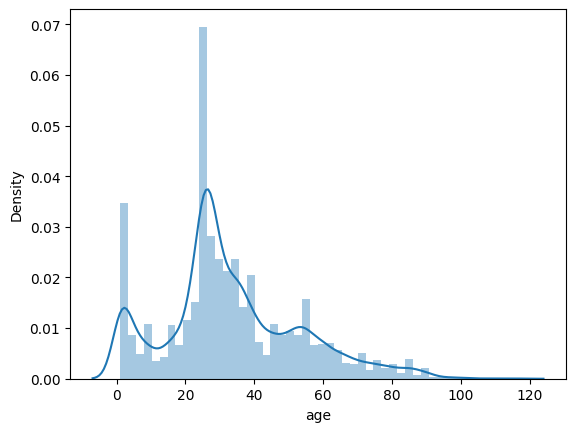

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

#Let's visualize age category first
sns.distplot(df['age'])

race
0                                 10078
1                                  4526
3                                  3975
2                                  3434
4                                  1692
20170116174525125.jpg.chip.jpg        1
20170109150557335.jpg.chip.jpg        1
20170109142408075.jpg.chip.jpg        1
Name: count, dtype: int64


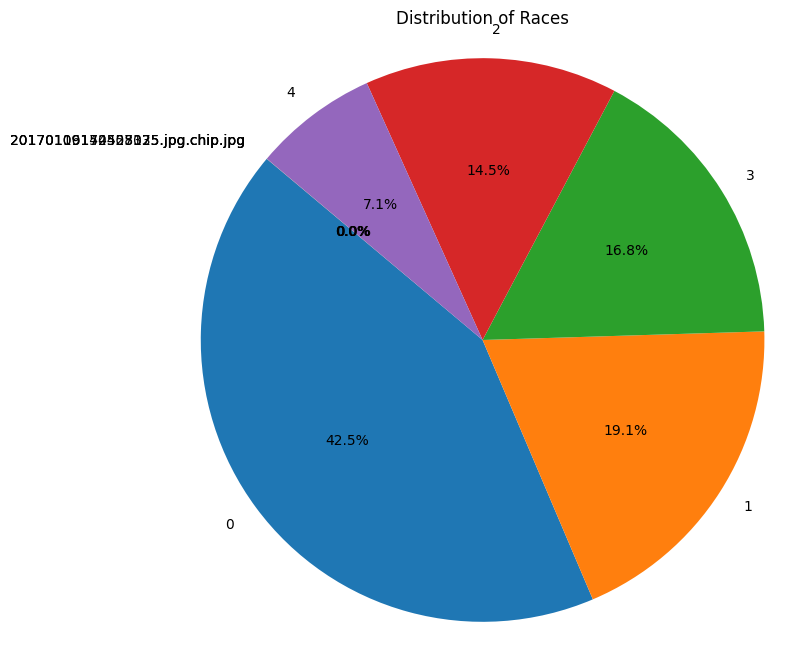

In [143]:
# delete abnormal rows || task to be assigned


race_counts = df['race'].value_counts()

print(race_counts)

plt.figure(figsize=(8, 8))
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Races')
plt.show()


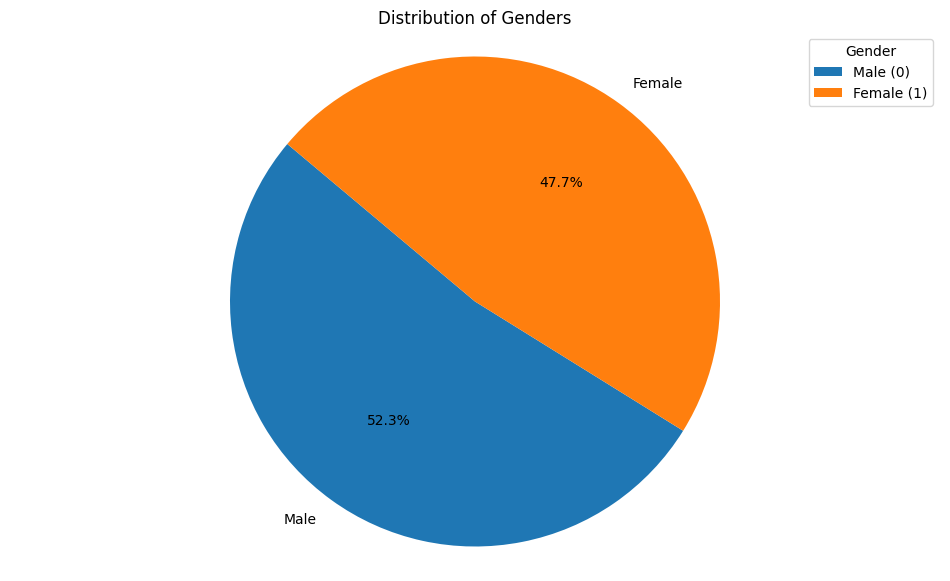

In [144]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the gender data
gender_counts = df['gender'].value_counts()

# Define labels for the gender values
gender_labels = ['Male', 'Female']

# Create the pie chart
plt.figure(figsize=(12, 7))
plt.pie(gender_counts, labels=gender_labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Genders')

# Add a legend
plt.legend(title='Gender', labels=['Male (0)', 'Female (1)'], loc='best')

# Show the plot
plt.show()


In [145]:
import cv2

In [146]:
!pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable


In [147]:
import cv2


image_dir = 'UTKFace'

image_arrays = []

for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):  

        img = cv2.imread(os.path.join(image_dir, filename))
        
        if img is not None:
            image_arrays.append(img)


image_array = np.array(image_arrays)

print("Shape of the NumPy array:", image_array.shape)


Shape of the NumPy array: (23708, 200, 200, 3)


In [148]:
#Converting dataset into numpy array

X = df.drop(['path'],axis =1).to_numpy()
y = image_array

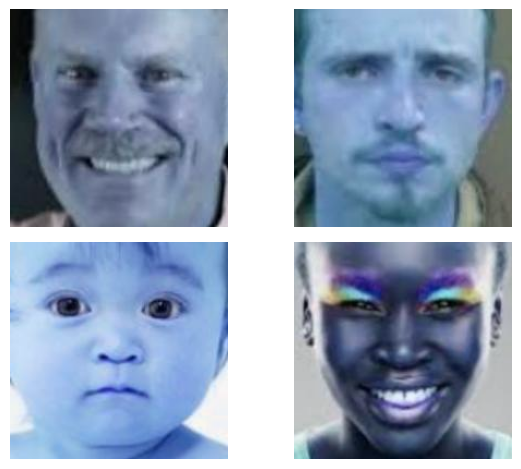

In [149]:
# Visualizing 5 random samples from y

randnums = np.random.randint(0, y.shape[0], 4)

fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(y[randnums[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [150]:
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.io import read_image


class CustomDataset(Dataset):

    def __init__(self,path,labels,transfrom=None):
        self.img_dir = path
        self.img_labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_labels.iloc[idx,0])
        image = read_image(img_path)
        # label = self.img_labels.iloc[idx, 1]

        label = tuple(map(int, self.img_labels.iloc[idx, 1]))
        if self.transform:
            image = self.transform(image)

        
        return image,label

# Here normalization component was a standard found from the internet

transform = transforms.Compose([  
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Resize the image to 28x28 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize image (for grayscale)
])

In [151]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['path'], df['gender'], test_size=0.2, random_state=42)


training_data = pd.concat([X_train,y_train],axis=1)

testing_data = pd.concat([X_test,y_test],axis=1)


In [118]:
training_dataset = CustomDataset('UTKFace', training_data, transform)
testing_dataset = CustomDataset('UTKFace', testing_data, transform)


In [119]:
from torch.utils.data import DataLoader

batch_size = 32
train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_dataset, batch_size=batch_size)


In [120]:
next(iter(train_dataloader))[0].shape# Test column

torch.Size([32, 1, 28, 28])

In [121]:
#making model for our dataset

from torch import nn

class LinearModel(nn.Module):

    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.layer(x)
        

In [122]:
# Initializing model, loss function and optimization functions

model = LinearModel(
    input_shape=28*28, # need to set variable for this
    hidden_units= 20,
    output_shape= 1
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr=0.01)

In [123]:
# dummy code for testing 

dummy_x = torch.rand([1,1,28,28])
model(dummy_x)

tensor([[0.3952]], grad_fn=<SigmoidBackward0>)

In [124]:
# code for training and testing 

from tqdm.auto import tqdm
from timeit import default_timer as timer
from helper_functions import accuracy_fn

torch.manual_seed(42)

EPOCHS = 10

train_loss = 0

train_loss_list = []
test_loss_list = []
accuracy_list = []

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch : {epoch}\n------")
    for batch,(X,y) in enumerate(train_dataloader):
        y_pred = model(X)
        loss = loss_fn(y_pred.squeeze(),y[0].to(torch.float32))
        train_loss += loss

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()

        if batch%520 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader)} samples.")

    train_loss /=len(train_dataloader)
    

    print(f"Training loss : {train_loss}")
    train_loss_list.append(train_loss)
    test_loss, test_acc = 0,0

    model.eval()
    
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model(X_test)

            test_loss+=loss_fn(test_pred.squeeze(),y_test[0].to(torch.float32))
            test_pred = (test_pred.squeeze() >= 0.5).float() 
            test_acc += accuracy_fn(y_true=y_test[0].to(torch.float32),y_pred = test_pred)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"Train loss: {train_loss:.4f} | Test loss : {test_loss:.4f} | Test acc : {test_acc:.4f}")
    test_loss_list.append(test_loss)
    accuracy_list.append(test_acc)



  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch : 0
------
Looked at 0/593 samples.
Looked at 16640/593 samples.
Training loss : 0.4926593601703644


 10%|████▍                                       | 1/10 [00:14<02:08, 14.24s/it]

Train loss: 0.4927 | Test loss : 0.4338 | Test acc : 80.9144
Epoch : 1
------
Looked at 0/593 samples.
Looked at 16640/593 samples.
Training loss : 0.42324143648147583


 20%|████████▊                                   | 2/10 [00:27<01:49, 13.66s/it]

Train loss: 0.4232 | Test loss : 0.4101 | Test acc : 81.9561
Epoch : 2
------
Looked at 0/593 samples.
Looked at 16640/593 samples.
Training loss : 0.4014234244823456


 30%|█████████████▏                              | 3/10 [00:40<01:34, 13.46s/it]

Train loss: 0.4014 | Test loss : 0.4176 | Test acc : 81.6625
Epoch : 3
------
Looked at 0/593 samples.
Looked at 16640/593 samples.
Training loss : 0.39094552397727966


 40%|█████████████████▌                          | 4/10 [00:53<01:20, 13.35s/it]

Train loss: 0.3909 | Test loss : 0.3858 | Test acc : 83.2774
Epoch : 4
------
Looked at 0/593 samples.
Looked at 16640/593 samples.
Training loss : 0.384458065032959


 50%|██████████████████████                      | 5/10 [01:08<01:09, 13.85s/it]

Train loss: 0.3845 | Test loss : 0.3763 | Test acc : 83.7598
Epoch : 5
------
Looked at 0/593 samples.
Looked at 16640/593 samples.
Training loss : 0.37860608100891113


 60%|██████████████████████████▍                 | 6/10 [01:22<00:54, 13.69s/it]

Train loss: 0.3786 | Test loss : 0.3701 | Test acc : 83.8017
Epoch : 6
------
Looked at 0/593 samples.
Looked at 16640/593 samples.
Training loss : 0.3743375539779663


 70%|██████████████████████████████▊             | 7/10 [01:35<00:40, 13.53s/it]

Train loss: 0.3743 | Test loss : 0.3696 | Test acc : 83.8437
Epoch : 7
------
Looked at 0/593 samples.
Looked at 16640/593 samples.
Training loss : 0.3700997531414032


 80%|███████████████████████████████████▏        | 8/10 [01:49<00:27, 13.92s/it]

Train loss: 0.3701 | Test loss : 0.3772 | Test acc : 83.2564
Epoch : 8
------
Looked at 0/593 samples.
Looked at 16640/593 samples.
Training loss : 0.3681298792362213


 90%|███████████████████████████████████████▌    | 9/10 [02:03<00:13, 13.79s/it]

Train loss: 0.3681 | Test loss : 0.3615 | Test acc : 84.4938
Epoch : 9
------
Looked at 0/593 samples.
Looked at 16640/593 samples.
Training loss : 0.3653993010520935


100%|███████████████████████████████████████████| 10/10 [02:17<00:00, 13.77s/it]

Train loss: 0.3654 | Test loss : 0.3598 | Test acc : 84.4100


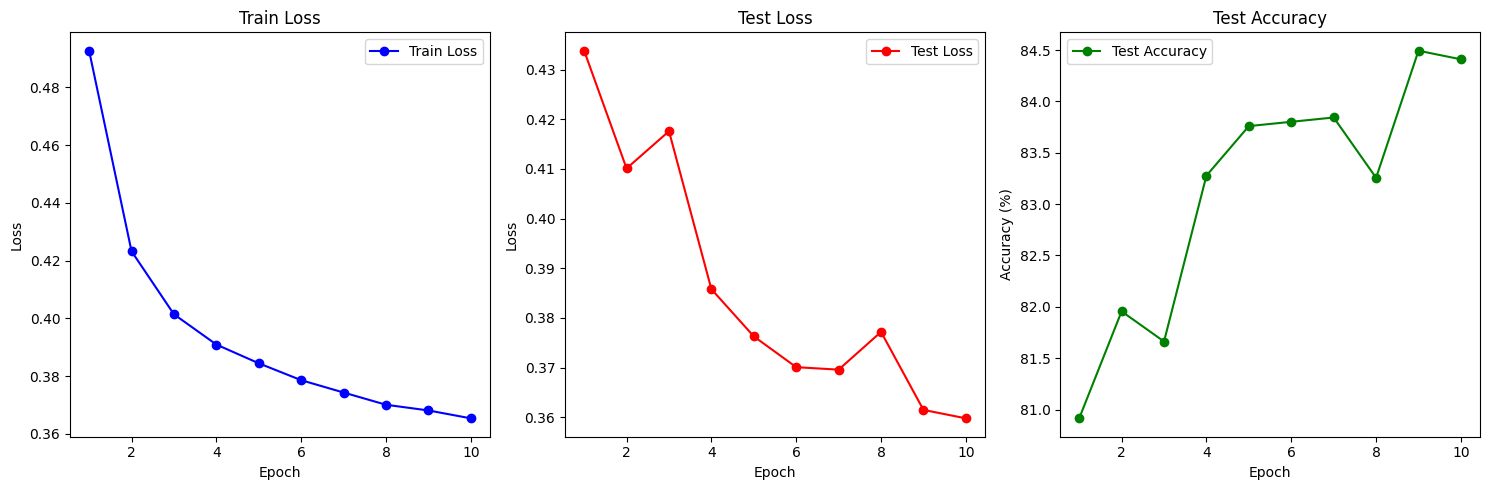

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# Hardcoded values for train loss, test loss, and test accuracy
train_loss_list = np.array([0.4926593601703644, 0.42324143648147583, 0.4014234244823456, 0.39094552397727966, 0.384458065032959, 0.37860608100891113, 0.3743375539779663, 0.3700997531414032, 0.3681298792362213, 0.3653993010520935])
test_loss_list = np.array([0.4338, 0.4101, 0.4176, 0.3858, 0.3763, 0.3701, 0.3696, 0.3772, 0.3615, 0.3598])
accuracy_list = np.array([80.9144, 81.9561, 81.6625, 83.2774, 83.7598, 83.8017, 83.8437, 83.2564, 84.4938, 84.4100])

epochs = range(1, len(train_loss_list) + 1)

# Create subplots in a single row with 1 row and 3 columns
plt.figure(figsize=(15, 5))

# Subplot 1: Train Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, label='Train Loss', marker='o', color='b')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot 2: Test Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, test_loss_list, label='Test Loss', marker='o', color='r')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot 3: Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, accuracy_list, label='Test Accuracy', marker='o', color='g')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [111]:
test_loss_list = [x.item() for x in test_loss_list]

In [116]:
train_loss_list

[0.36528724431991577,
 0.36528724431991577,
 0.36528724431991577,
 0.36528724431991577,
 0.36528724431991577,
 0.36528724431991577,
 0.36528724431991577,
 0.36528724431991577,
 0.36528724431991577,
 0.36528724431991577]